In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

from scbeta_scrnaseq.figure_vis import core_colors
import scbeta_scrnaseq.figure_vis as fv


fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
samples = ["exo"]


tds = OrderedDict()
for tp in samples:
    loom_fn = f'../02_Stage_6/data/pseudotime/stage6.exo.loom'
    tds[tp] = loompy.connect(loom_fn)
    tds[tp].vals = sp.sparse.csr_matrix(tds[tp].layers[""][:, :])

In [3]:
import glob

pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [4]:
exo_labels = {
    'early_exo': {
        'color': core_colors.green,
        'short_label': 'Early exo prog.'},
    'late_exo': {
        'color':core_colors.dark_green,
        'short_label': 'Late exo prog.'},
    'ductal_like': {
        'color': fv.to_array_col(palettable.wesanderson.Moonrise5_6.colors[3]),
        'short_label': 'Ductal-like'},
    'acinar_like': {
        'color': fv.to_array_col(palettable.wesanderson.Moonrise5_6.colors[2]),
        'short_label': 'Acinar-like'},
    'mesenchymal': {
        'color': fv.to_array_col(palettable.cartocolors.qualitative.Pastel_8.colors[-1]),
        'short_label': 'Mesenchymal-like'},
    }

label_order = ['early_exo', 'late_exo', 'ductal_like', 'acinar_like', 'mesenchymal']
ratio_order = ['early_exo', 'late_exo', 'ductal_like', 'acinar_like', 'mesenchymal']

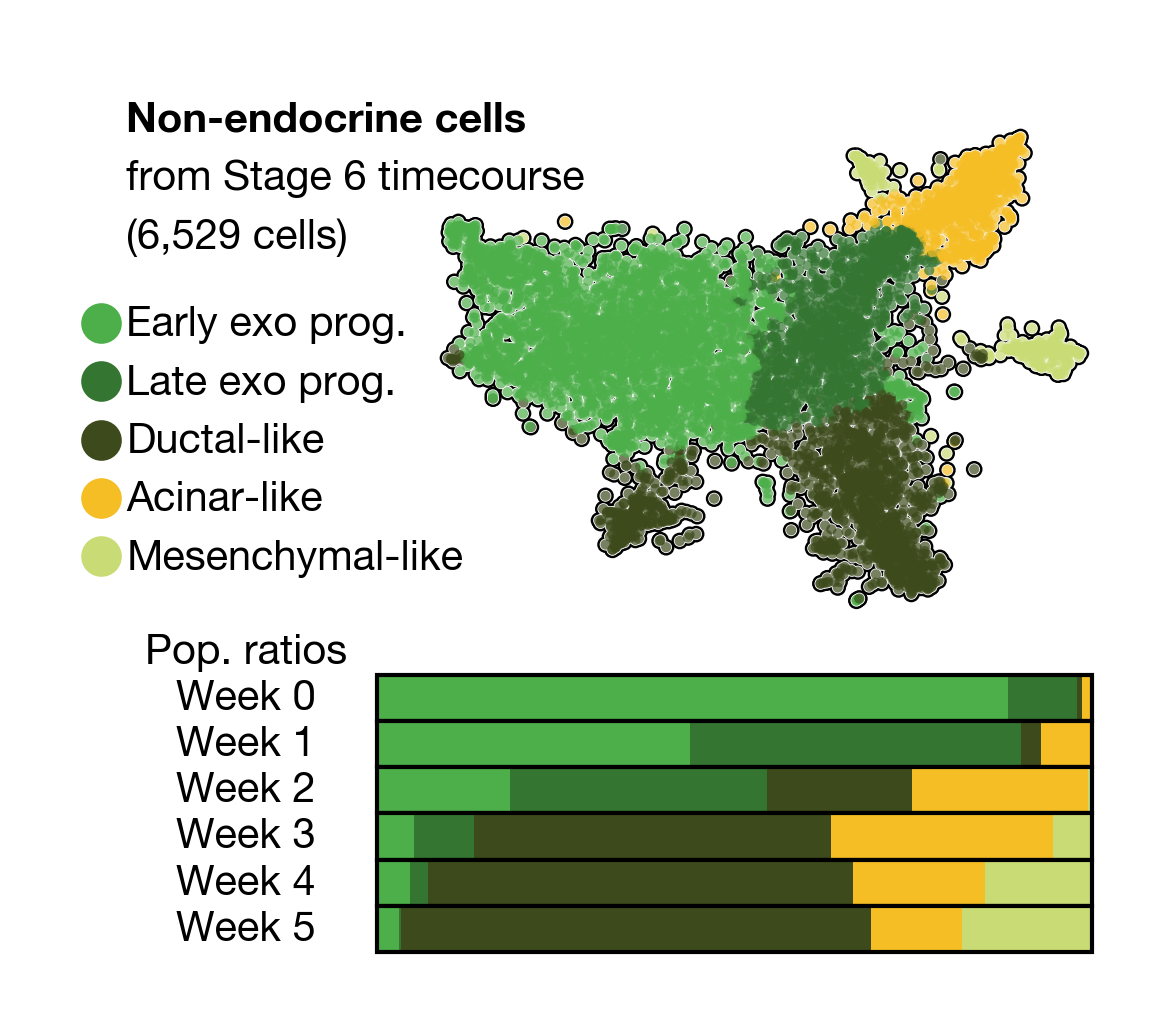

In [17]:

panel_sizing = ((89/2)/mm_per_inch, #Width
                (1.5*25.4)/mm_per_inch, #Height
                ) 

cell_pop_bar_h = 0.07

heights = [(1 - cell_pop_bar_h)*panel_sizing[1]] + [cell_pop_bar_h * panel_sizing[1]]*6
widths = [panel_sizing[0] - heights[0]] + [heights[0]]


fig = plt.figure(figsize=panel_sizing, dpi=600)


gs = gridspec.GridSpec(7, 2, fig, 0,0.01,1,1, hspace=0, wspace=0,
                       width_ratios=widths,
                       height_ratios=heights)

    
si = 0
_ds = tds['exo']
tsne_proj = _ds.ca['TSNE']
cell_week = _ds.ca['CellWeek']
cell_clusters = _ds.ca['ExoLabels']
label_params = exo_labels

###### Draw the labels
# 
#

ax = fig.add_subplot(gs[0, 2*si + 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])

li = 1
yl_pos = lambda lii: 1 - lii/10.5
xl_pos_dot = 0.18
xl_pos_header = 0.30
xl_pos_text = 0.30

ax.text(xl_pos_header, yl_pos(li), 'Non-endocrine cells', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_header, yl_pos(li), 'from Stage 6 timecourse', verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1

ax.text(xl_pos_header, yl_pos(li), '(%s cells)'%format(len(tsne_proj),',d'), verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

_present_labels = set(cell_clusters)
for lb in [lb for lb in label_order if lb in _present_labels]:
    lb_text = label_params[lb]['short_label']
    ax.scatter(xl_pos_dot, yl_pos(li)+0.004, s=fv.tsne_legend_ms, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
    for leg_label_line in lb_text.splitlines():            
        ax.text(xl_pos_text, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5,clip_on=False)
        li += 1

###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_clusters, label_params) 

ax = fig.add_subplot(gs[0, 2*si + 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

s_black, s_white, s_type = 4, 2, 1.5
ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=0.7,
               rasterized=True)

# Place the tSNE further to the top, right
old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.2
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.5, old_ylim[1] + shift_amt*(y_span)*0.5])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

###### Population Ratio Indicator
# 
#

for wk in range(6):

    ax = fig.add_subplot(gs[1 + wk, (2*si):(2*si + 2)], 
                  xticks=[], yticks=[],       
                  xlim=[0,1], ylim=[0,1],
                  xscale='linear', yscale='linear',
                  frameon=False)

    n_by_cluster = pd.Series(Counter(cell_clusters[cell_week == wk]))
    n_by_cluster = n_by_cluster/n_by_cluster.sum()

    cumul_frac = 0
    for lb in ratio_order:
        if lb in n_by_cluster:
            cl_frac = n_by_cluster[lb]
            ax.add_patch(
                patches.Rectangle(
                    (0.30 + 0.68*cumul_frac, 0.02), (0.68*cl_frac), 1.0,
                    facecolor=label_params[lb]['color'], edgecolor='none',
                    clip_on=False,
                ))
            cumul_frac += cl_frac

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    if wk==0:
        ax.text(0.175, 1.5, 'Pop. ratios', verticalalignment='center', horizontalalignment='center', fontsize=5,
        clip_on=False)
        
    ax.text(0.175, 0.5, f'Week {wk}', verticalalignment='center', horizontalalignment='center', fontsize=5,
            clip_on=False)
    ax.add_patch(
            patches.Rectangle(
                (0.30, 0.02), 0.68, 1.0,
                facecolor='none', edgecolor='k', linewidth=0.5, clip_on=False,
            ))

fig.savefig('../../figures/components/extended_figure6/ExtendedFigure6C.pdf', dpi=600, transparent=True)


In [5]:
ds = tds['exo']
tpm_normalizer = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
tpm_normalizer.fit(ds.vals)

tpm_z_normalizer = cgm.CountsNormalizer()
tpm_z_normalizer.fit(ds.vals)

In [6]:
genes = ['LIN28A', 'SPARC', 'KRT19', 'PTF1A', 'CLPS', 'VIM']

regressed_expr_values = {}

for g in genes:
    
    gi = np.where(ds.ra.Gene==g)[0]
    expr_values = tpm_normalizer.transform(ds.vals, genes=gi).T    
    
    if expr_values.shape[1] == 0:
        print(g)
        continue
        
    reg = fv.proj_regressor(tsne_proj, expr_values, radius=1, weights='uniform')
    pred_values = reg.predict(tsne_proj).ravel()
    
    pred_values = pred_values/np.percentile(pred_values, 98)
    pred_values = np.log10(pred_values + 0.01)
    regressed_expr_values[g] = pred_values
    


NameError: name 'tsne_proj' is not defined

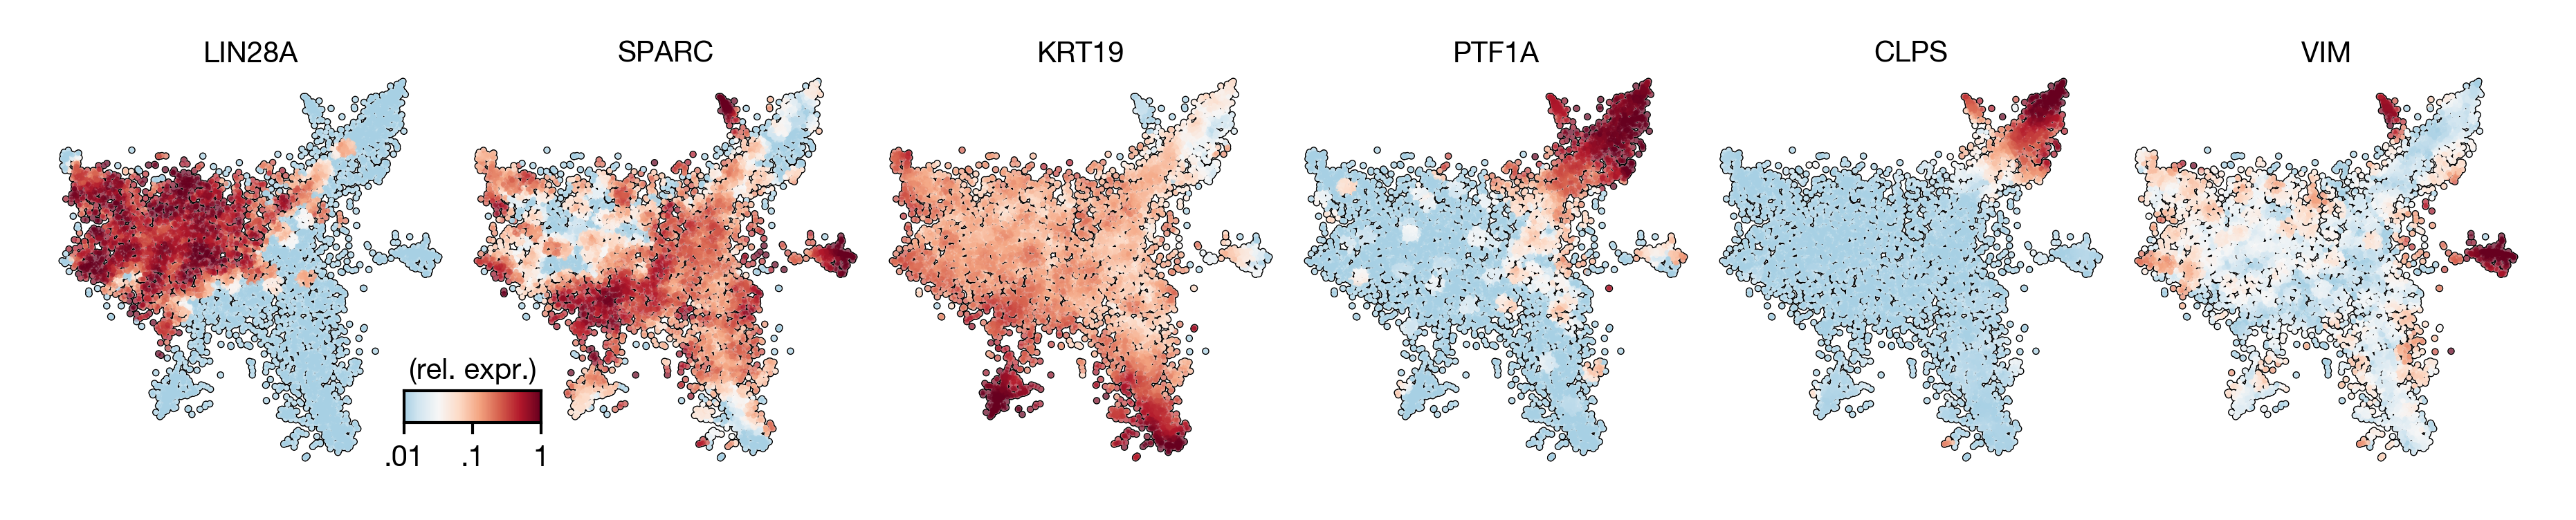

In [12]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
vmin, vmax = -3, 0



sm_display_s = 0.8
sm_outline_s = 2

###### Draw the labels
# 
#

ggrp =['LIN28A', 'SPARC', 'KRT19', 'PTF1A', 'CLPS', 'VIM']
    
fig = plt.figure(figsize=(6, 1.10), dpi=600)

gs = gridspec.GridSpec(2, 6, fig, 0,0,1,1, hspace=0, wspace=0,
                   height_ratios=[0.1, 1])

for ci,g in enumerate(ggrp):
# for ci,g in enumerate(['TOP2A', 'AURKB', 'AURKA', 'CDKN1C', ]):


    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(g, pad=0)
    
    _proj = tsne_proj
    if g not in regressed_expr_values:
        continue
        
    s_black, s_white, s_type = 1.6, 0.8, 0.8
    ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black, 
                   rasterized=True)
    ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
                   rasterized=True)
    imax = ax.scatter(_proj[:, 0], _proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
                      s=s_type, alpha=0.7,
                      cmap='RdBu_r', vmin=vmin, vmax=vmax,
                   rasterized=True)
    
    ax.patch.set_visible(False)


##### Draw the labels
# 
#

cvmin = -2
cvmax = 0
colorbar_ax_position = [0.145, 0.12, 0.055, 0.07]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)

xticks = np.linspace(cvmin, cvmax, 5).astype(int)
colorbar_ax.set_xticks([-2, -1, 0])
colorbar_ax.set_xticklabels(['.01', ".1", "1"], fontsize=5);

colorbar_ax.set_title('(rel. expr.)', fontsize=5, pad=2);

fig.savefig('../../figures/components/extended_figure6/ExtendedFigure6B.pdf', dpi=600, transparent=True)


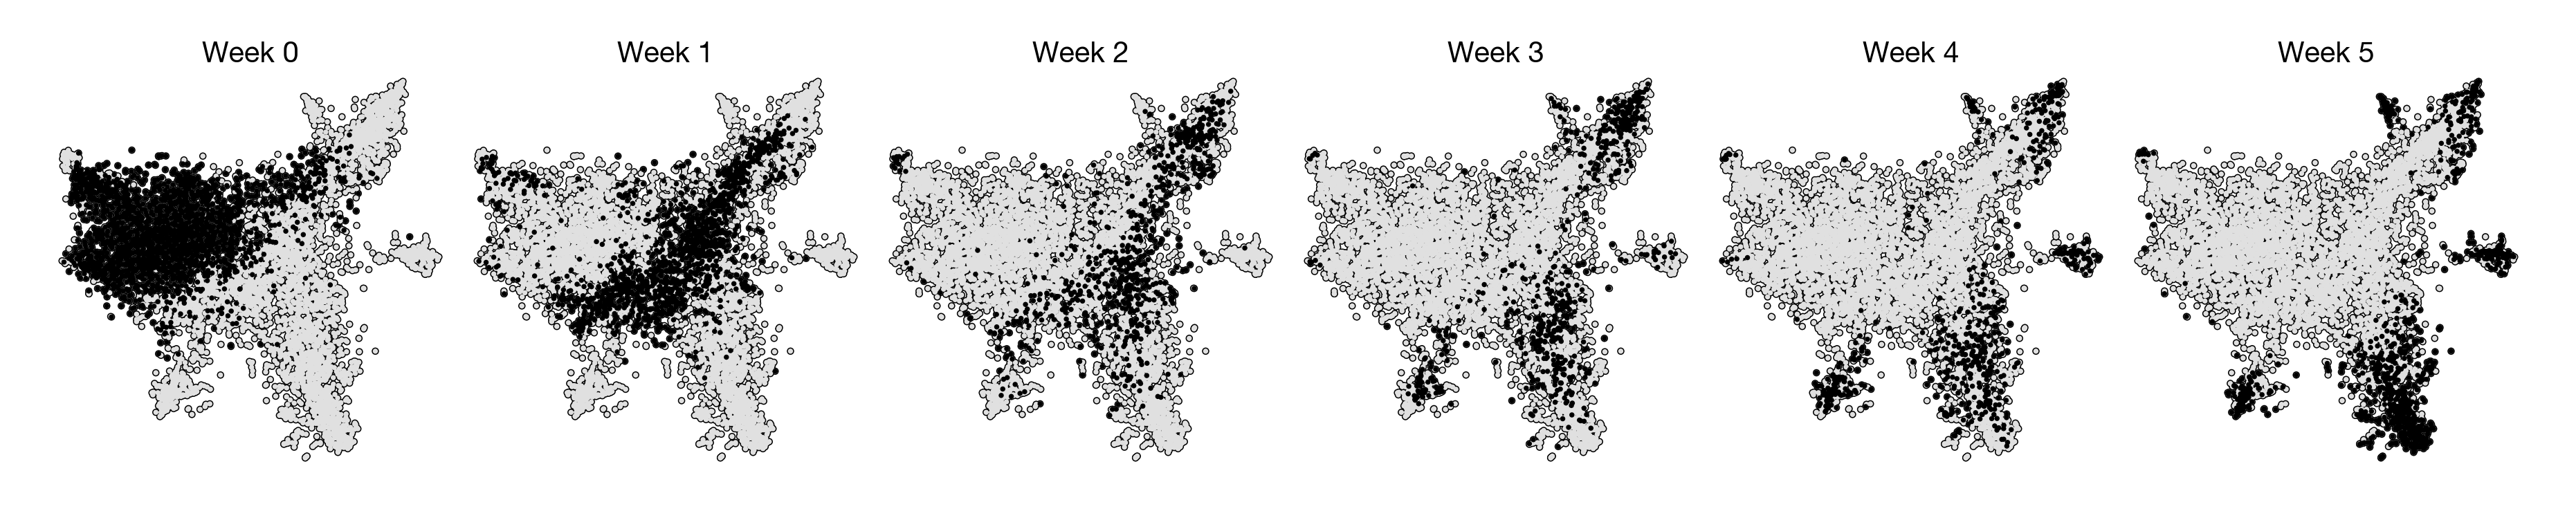

In [15]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
fig = plt.figure(figsize=(6, 1.10), dpi=600)

gs = gridspec.GridSpec(2, 6, fig, 0,0,1,1, hspace=0, wspace=0,
                       height_ratios=[0.1, 1])


sm_display_s = 0.8
sm_outline_s = 1.6

###### Draw the labels
# 
#

for wk in range(6):
    ci = wk
    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(f'Week {wk}', pad=0)
    
    s_black, s_white, s_type = 1.6, 0.8, 0.8
    ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black, 
                   rasterized=True)
    ax.scatter(_proj[:, 0], _proj[:, 1], c='#e0e0e0', edgecolor='none', s=s_white, 
                   rasterized=True)

    cell_day_filter = ds.ca.CellWeek==wk
    
    imax = ax.scatter(tsne_proj[cell_day_filter, 0], tsne_proj[cell_day_filter, 1], c='k', edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    ax.patch.set_visible(False)


##### Draw the labels
# 
#


fig.savefig('../../figures/components/extended_figure6/ExtendedFigure6A.pdf', dpi=600, transparent=True)


In [7]:



cluster_order = [
    ('exo.labels', 'early_exo'),
    ('exo.labels', 'late_exo'),
    ('exo.labels', 'ductal_like'),
    ('exo.labels', 'acinar_like'),
    ('exo.labels', 'mesenchymal'),
    
    ('stage6.labels', 'scbeta'),
    ('stage6.labels', 'ec'),
    ('stage6.labels', 'ph'),
][::-1]

def combine_rows(dfs, rows, na=0):
    new_df = OrderedDict({})
    for inrow in rows:
        if len(inrow) == 2:
            df, row = inrow
            label = f"{df} {row}"
        elif len(inrow) == 3:
            df, row, label = inrow
            
        new_df[label] = dfs[df].loc[row]
    new_df = pd.DataFrame(new_df).fillna(na).T
    return new_df

cluster_tpm = combine_rows(pb_tpm, cluster_order)
cluster_expr = combine_rows(pb_expr, cluster_order)

In [8]:
g_grp = [["LIN28A", 'CDH26', 'KLF9', 'GYPC', 'CDX2'],
         ['ANGPT2', 'SPOCK1', 'DKK2', 'CDH7', 'SOX9',],
         ["LCP1", "KRT19", "KRT17", "MUC1", "CFTR",],
         ["PTF1A", "CPA1", "CPA2", "CTRB1", "CTRB2", ],
         ["VIM", "SPARC", "COL3A1", "COL1A1", "PDGFRB", ],
]

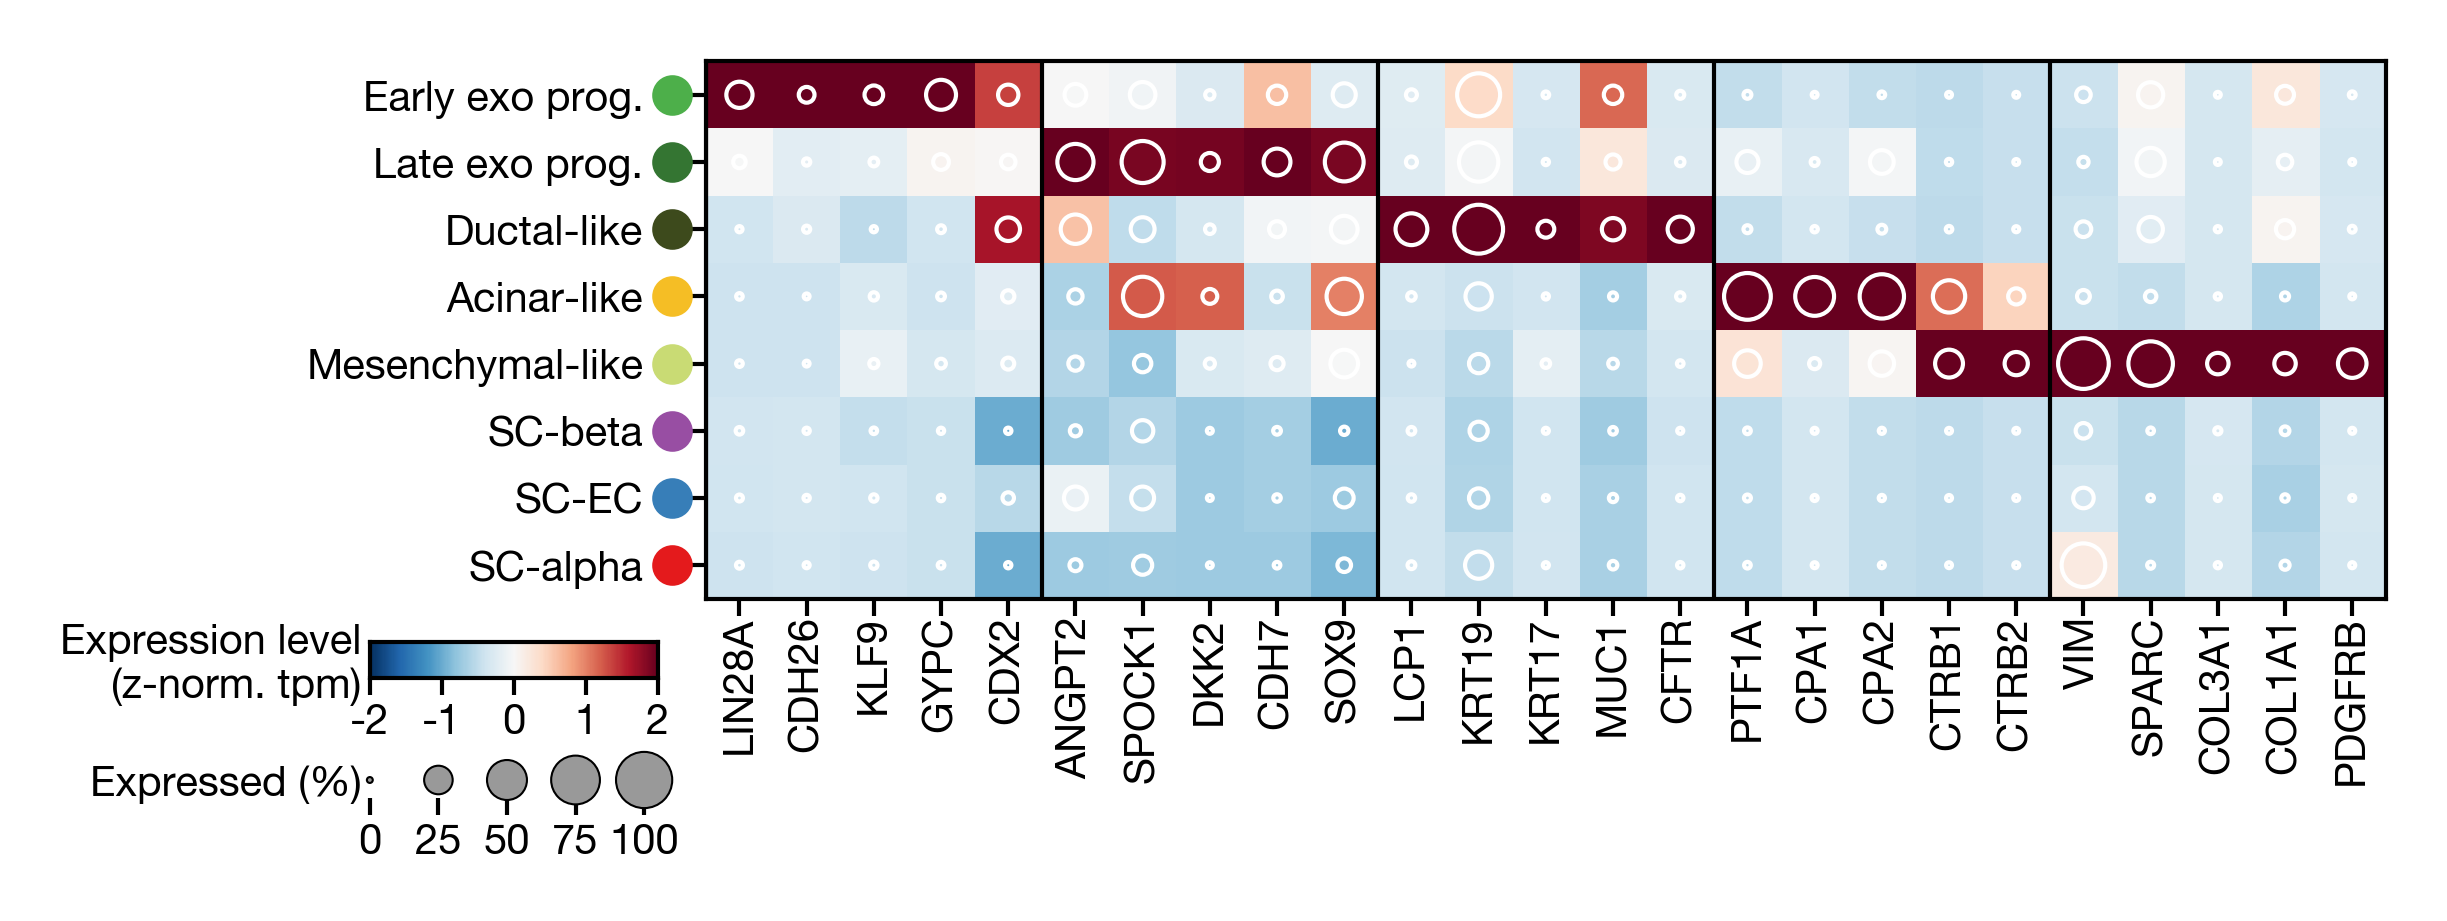

In [13]:
label_params = fv.dataset_label_params('stage6')
label_params.update(exo_labels)

cmap = "RdBu_r"

norm_tpm = cluster_tpm.copy()# + 1

norm_tpm -= norm_tpm.mean(0)
norm_tpm /= norm_tpm.std(0)
vmin, vmax = (-2, 2)

# norm_tpm /= norm_tpm.max(0)
# norm_tpm = np.log10(norm_tpm + 0.01)
# vmin, vmax = (-3, 0)

display_genes = g_grp[0] + g_grp[1]+ g_grp[2]+ g_grp[3]+ g_grp[4]
_tpm = norm_tpm[display_genes].values
_frac = cluster_expr[display_genes].values

_y, _x = np.mgrid[:_tpm.shape[0], :_tpm.shape[1]]
_x = _x.ravel()
_y = _y.ravel()


###### Main plot
# 
#

fig = plt.figure(figsize=(4,2), dpi=600)

ax = fig.add_axes([0.29, 0.26, 0.70, 0.7],
              xscale='linear', yscale='linear',
            xlabel='', ylabel='', frameon=True)
ax.set_axisbelow(True)

# Draw fancy y tick labels
ax.set_yticks(range(len(cluster_order)))
tick_labels = []
for stg, cl in cluster_order:
#     label_params = fv.dataset_label_params(stg.split('.')[0])
    tick_labels.append(f"{label_params[cl]['short_label']}")
ax.set_yticklabels(tick_labels)

ax.set_xticks(range(len(g_grp)))
ax.set_xticklabels(g_grp, rotation=90, fontsize=5)

ax.tick_params(axis='x', which='major', pad=0, width=0.5, zorder=-10)
ax.tick_params(axis='y', which='major', pad=6, width=0.5, zorder=-10)
for ci, (stg, cl) in enumerate(cluster_order):
    ax.scatter(-1, ci, s=fv.heatmap_legend_ms, clip_on=False, c=label_params[cl]['color'].reshape(1,-1))

# Draw data points

ax.imshow(_tpm, cmap='RdBu_r', vmin=vmin, vmax=vmax)
imax = ax.scatter(_x, _y, s=0.5 + _frac.ravel()*45, c=_tpm.ravel(),
#            linewidth=0.25,  edgecolor=core_colors.grey,
            linewidth=0.5, edgecolor='w',
           cmap=cmap, vmin=vmin, vmax=vmax, 
          )

# Fix plot limits
ax.set_xticks(range(len(display_genes)))
ax.set_xticklabels(display_genes, rotation=90, fontsize=5);
ax.set_xlim([-0.50, len(display_genes)-0.5])
ax.set_ylim([-0.50, len(cluster_order)-0.5])


###### Boxes and vertical lines
# 
#

gc = 0
samples_per_group = [(0, 2), (2, 3), (5, 2), (0, 7), (7, 4), (11, 2)]
g_group_color = [core_colors.purple, core_colors.red, core_colors.blue, core_colors.brown, core_colors.green, core_colors.grey]
for i,(g, (s1, s2), cc) in enumerate(zip(g_grp ,samples_per_group, g_group_color)):
    n_gs = len(g)
    grp_color = cc
    ax.add_patch(
            patches.Rectangle(
                (gc-0.5, -0.5 + len(cluster_order) - s1 - s2), n_gs, s2,
                facecolor=grp_color, alpha=0.2,
                edgecolor='none', linewidth=0.5, zorder=-10
            ))
    ax.axvline(gc-0.5, c='k', linewidth=0.5)
    gc += n_gs
    
ax.tick_params(axis='y', which='major', pad=5.5)

###### Colorbar
# 
#

colorbar_ax_position = [0.15, 0.32, 0.12, 0.03]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[0.5],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(-2, 2, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(-2,2,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='y', length=0)

xticks = np.linspace(-2, 2, 5).astype(int)
colorbar_ax.set_xticks(xticks)
colorbar_ax.set_xticklabels(xticks, fontsize=5);

colorbar_ax.set_yticklabels(['Expression level\n(z-norm. tpm)'], fontsize=5);

###### Expression % legend
# 
#

size_ax_position = [0.15, 0.22, 0.12, 0.03]
size_ax = fig.add_axes(size_ax_position,
                xscale='linear', yscale='linear', yticks=[0], xticks=range(5),
                xlabel='', ylabel='', frameon=False, )

size_ax.scatter(range(5), np.zeros(5), s=0.5 + np.linspace(0,1,5)*45, facecolor=core_colors.grey,
                edgecolor='k',linewidth=0.25, clip_on=False)
size_ax.set_xlim([0,4.2])
size_ax.tick_params(axis='y', length=0)
size_ax.set_xticklabels(['0', '25', '50', '75', '100'], fontsize=5);
size_ax.set_axisbelow(True)
size_ax.set_yticklabels(['Expressed (%)'], fontsize=5);

fig.savefig('../../figures/components/extended_figure6/ExtendedFigure6D.pdf', dpi=600, transparent=True)
